In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error
from scipy.stats import uniform, randint

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedKFold, KFold


/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
STATS_COLUMNS = ["player", "position", "age","team_id","g","gs","mp_per_g","fg_per_g",
"fga_per_g","fg_pct","fg3_per_g","fg3a_per_g","fg3_pct","fg2_per_g","fg2a_per_g",
"fg2_pct","efg_pct","ft_per_g","fta_per_g","ft_pct","orb_per_g","drb_per_g","trb_per_g",
"ast_per_g","stl_per_g","blk_per_g","tov_per_g","pf_per_g","pts_per_g"]
NUM_STATS_COLUMNS = [col for col in STATS_COLUMNS if col not in ('"player", "position","team_id"')]

ADVANCED_STATS_COLUMNS =["player","position","age","team_id","g","mp","per","ts_pct","fg3a_per_fga_pct",
"fta_per_fga_pct","orb_pct","drb_pct","trb_pct","ast_pct","stl_pct","blk_pct","tov_pct","usg_pct",
                         "ows","dws","ws","ws_per_48","obpm","dbpm","bpm","vorp"]

NUM_ADVANCED_STATS_COLUMNS = [col for col in ADVANCED_STATS_COLUMNS if col not in ('"player", "position","team_id"')]
INJURIES_COLUMNS = ['out_for_season', 'out_indefinitely','acum_out_for_season', 'acum_out_indefinitely']

In [3]:
df = pd.read_csv('datasets/preprocessed_dataset.csv').fillna(0).set_index('player')
results_df = pd.read_csv('datasets/results/performance_metrics.csv')

In [4]:
relevant_cols = list(set(NUM_STATS_COLUMNS + NUM_ADVANCED_STATS_COLUMNS + ['position'] + INJURIES_COLUMNS))

In [5]:
def evaluate_predictions(model, dataset_type, y_pred, y_truth):
    rmse = np.round(np.sqrt(mean_squared_error(y_truth, y_pred)), 0)
    mae = np.round(median_absolute_error(y_truth, y_pred), 0)
    mape = np.round(mean_absolute_percentage_error(y_truth, y_pred), 4)
    return {'model': [model], 'dataset_type': [dataset_type], 'rmse':[rmse], 'mae': [mae], 'mape':[mape]}

class PredictionEvaluation:
    
    def __init__(self, y_pred_train, y_truth_train, y_pred_test, y_truth_test, model_name, results_df):
        self.y_pred_train = y_pred_train
        self.y_truth_train = y_truth_train
        self.y_pred_test = y_pred_test
        self.y_truth_test = y_truth_test
        self.model_name = model_name
        self.results_df = results_df        
    
    def fill_results_df(self):
        train_results = pd.DataFrame(evaluate_predictions(self.model_name, 'train',
                                                          self.y_pred_train, self.y_truth_train))
        test_results = pd.DataFrame(evaluate_predictions(self.model_name, 'test',
                                                         self.y_pred_test, self.y_truth_test))
        return pd.concat([self.results_df, train_results, test_results])

    def diagnostics_plots(y_pred, y_truth):
    
        diag_plot = pd.DataFrame({'y_pred':y_pred,'y':y_truth, 'error': y_pred-y_truth})
        diag_plot.plot.scatter(x='y',y='y_pred')
        plt.plot([0,max(y_truth)], [0,max(y_truth)], c='black')
        plt.show()

In [6]:
X = df[relevant_cols+['free_agency_year']]
y = df[['mean_salary','free_agency_year']]

In [7]:
X['position'] = X.position.str.split('-').apply(lambda x: x[0])
X = pd.get_dummies(X, columns=["position"])

/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
x_columns = X.columns.to_list()
x_columns.remove('free_agency_year')

In [9]:
train_X, test_X = X.query('free_agency_year < 2020').drop('free_agency_year', axis=1),\
                  X.query('free_agency_year == 2020').drop('free_agency_year', axis=1)#.values
train_y, test_y = y.query('free_agency_year < 2020').drop('free_agency_year', axis=1).mean_salary,\
                  y.query('free_agency_year == 2020').drop('free_agency_year', axis=1).mean_salary#.values

In [38]:
params = {
        'n_estimators': randint(50, 400),
        'min_samples_leaf': randint(1, 21),
        'max_features': uniform(0.30, 0.15),
        'max_depth': randint(3, 10),
        'max_samples': randint(int(train_X.shape[0]*0.75), train_X.shape[0])
        }

In [73]:
rf = RandomForestRegressor(criterion = 'mse',n_jobs=4, random_state=1992)

In [74]:
folds = 5
param_comb = 20
repeats = 3

kf = RepeatedKFold(n_splits=folds, n_repeats=repeats, random_state = 1992)

In [75]:
random_search = RandomizedSearchCV(rf, param_distributions=params,
                                   n_iter=param_comb, scoring='neg_median_absolute_error',
                                   n_jobs=6, cv=kf.split(train_X,train_y), verbose=2, random_state=1992 )

In [76]:
random_search.fit(train_X,train_y)

Fitting 15 folds for each of 20 candidates, totalling 300 fits


/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [              nan -1873027.12257325 -1895152.00653391 -1851912.94564947
               nan               nan               nan               nan
               nan -1876377.77262824               nan               nan
               nan               nan               nan               nan
               nan -1838393.05877425 -1861106.25323817               nan]
  category=UserWarning


RandomizedSearchCV(cv=<generator object _RepeatedSplits.split at 0x7f5b56b53cf0>,
                   estimator=RandomForestRegressor(n_jobs=4, random_state=1992),
                   n_iter=20, n_jobs=6,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5b5778e588>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5b5778e4e0>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5b5778e1d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5b5778ed68>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5b5778e668>},
                   random_state=1992, scoring='neg_median_absolute_error',
                   verbose=2)

In [77]:
print('Best estimator:')
print(random_search.best_estimator_)

Best estimator:
RandomForestRegressor(max_depth=5, max_features=0.44046566880854815,
                      max_samples=745, min_samples_leaf=8, n_estimators=92,
                      n_jobs=4, random_state=1992)


In [43]:
print('Best estimator:')
print(random_search.best_estimator_)

Best estimator:
RandomForestRegressor(criterion='mae', max_depth=8,
                      max_features=0.3970709996672875, max_samples=739,
                      min_samples_leaf=9, n_estimators=58, n_jobs=4,
                      random_state=1992)


In [78]:
random_search.best_score_

-1838393.0587742524

In [79]:
random_search.best_score_

-1838393.0587742524

In [80]:
train_y_pred = random_search.predict(train_X)
test_y_pred = random_search.predict(test_X)


In [81]:
median_absolute_error(train_y, train_y_pred)

1659394.422479735

In [82]:
median_absolute_error(test_y, test_y_pred)

1225906.203810359

/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/juan/anaconda3/envs/jmb_ds_projects/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


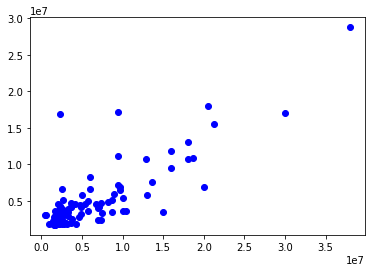

In [83]:
plt.plot(test_y, test_y_pred,'bo')

In [84]:
mean_absolute_percentage_error(test_y, test_y_pred)

0.5081561500406646

In [85]:
np.sqrt(mean_squared_error(test_y, test_y_pred))

3664722.2591350283

In [49]:
results_df

,model,dataset_type,rmse,mae,mape
0,baseline,train,7046669.0,4191739.0,1.7206
1,baseline,test,6136372.0,3988694.0,1.5356
2,modelo lineal,train,3924033.0,2111549.0,0.8302
3,modelo lineal,test,3559228.0,2088352.0,0.8496
4,modelo lineal no negativo,train,4343415.0,2166715.0,0.8812
5,modelo lineal no negativo,test,3798000.0,1817943.0,0.7398
6,modelo lineal logaritmo,train,4492837.0,1382346.0,0.5387
7,modelo lineal logaritmo,test,4095432.0,1059238.0,0.4941
8,lasso,train,3958471.0,2031632.0,0.8034
9,lasso,test,3501706.0,1819077.0,0.7776


In [86]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,param_n_estimators,params,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
1,0.902634,0.250235,0.105400,0.003779,8,0.397071,739,9,58,"{'max_depth': 8, 'max_features': 0.39707099966...",...,-1.627071e+06,-1.585514e+06,-1.982501e+06,-1.741912e+06,-1.525916e+06,-1.535618e+06,-1.650247e+06,-1.672899e+06,132354.940889,1
9,1.126543,0.081784,0.112228,0.009899,8,0.442079,743,7,53,"{'max_depth': 8, 'max_features': 0.44207871718...",...,-1.616253e+06,-1.497641e+06,-2.028915e+06,-1.735579e+06,-1.564748e+06,-1.697651e+06,-1.443586e+06,-1.678002e+06,163529.220137,2
3,0.758692,0.056486,0.104271,0.000896,7,0.424654,735,7,66,"{'max_depth': 7, 'max_features': 0.42465383381...",...,-1.708048e+06,-1.596445e+06,-1.958680e+06,-1.765648e+06,-1.508069e+06,-1.357849e+06,-1.593347e+06,-1.678747e+06,162762.643364,3
2,1.189351,0.305109,0.114771,0.019685,7,0.315095,706,3,105,"{'max_depth': 7, 'max_features': 0.31509497380...",...,-1.743262e+06,-1.638064e+06,-2.012433e+06,-1.901261e+06,-1.669920e+06,-1.624567e+06,-1.562959e+06,-1.735374e+06,147373.879454,4
0,0.003262,0.000943,0.000000,0.000000,4,0.363223,892,12,319,"{'max_depth': 4, 'max_features': 0.36322302777...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,0.003724,0.000945,0.000000,0.000000,8,0.352164,822,11,52,"{'max_depth': 8, 'max_features': 0.35216369060...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
5,0.005846,0.004849,0.000000,0.000000,9,0.370639,872,14,215,"{'max_depth': 9, 'max_features': 0.37063913403...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
6,0.004158,0.000799,0.000000,0.000000,6,0.307071,928,10,343,"{'max_depth': 6, 'max_features': 0.30707053601...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
7,0.006338,0.005698,0.000000,0.000000,7,0.338241,911,11,325,"{'max_depth': 7, 'max_features': 0.33824135047...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
8,0.005260,0.006497,0.000000,0.000000,3,0.447659,819,12,162,"{'max_depth': 3, 'max_features': 0.44765918595...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
